In [56]:
#Task 1: Fit the parameters of Pantheon model to the data

In [57]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt


In [58]:
#model function
def model(z, Omega_m):
    return np.sqrt(Omega_m*(1+z)**3 + (1-Omega_m))

In [59]:
#data collection
z = np.array([0.07, 0.2, 0.35, 0.55, 0.9, 1.50])
E = np.array([0.994, 1.113, 1.122, 1.369, 1.540, 2.690])
E_err = np.array([0.023, 0.020, 0.037, 0.063, 0.120, 0.690])
#Note that the errors are in the form of standard deviation
#the last error of E has +0.86 and -0.52, we take the average of the two as the error

In [60]:
#fit the model to the data and find the best fit parameters
#we set the initial value of Omega_m to be 0.3
popt, pcov = opt.curve_fit(model, z, E, p0=0.3, sigma=E_err, absolute_sigma=True)

# Extracting the standard errors in the fit parameters, from the covariance matrix diagonal
pcov_diag = np.sqrt(np.diag(pcov))

# Print the best fit parameters and their errors
print('Omega = %5.3f \u00b1 %5.3f' % (popt[0], pcov_diag[0]))

Omega = 0.261 ± 0.030


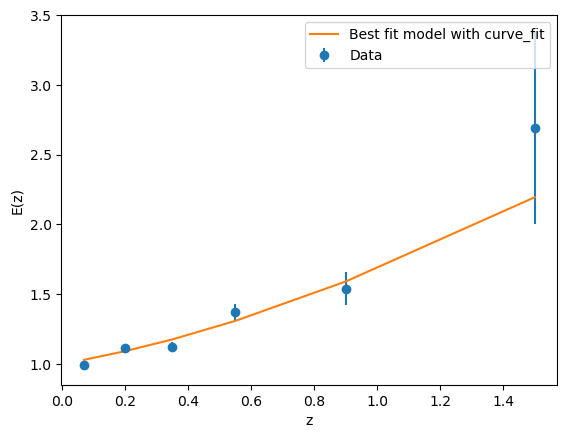

In [61]:
#plotting the data and the best fit model
plt.errorbar(z, E, yerr=E_err, fmt='o', label='Data')
plt.plot(z, model(z, popt[0]), label='Best fit model with curve_fit')
plt.xlabel('z')
plt.ylabel('E(z)')
plt.legend()
plt.show()  

In [62]:
#Instead of using the curve_fit function, we use the iminuit package to fit the model to the data
from iminuit import Minuit
#we define the least square function
def LSQ(Omega_m):
        return np.sum(((model(z, Omega_m) - E)/E_err)**2)
#we set the initial value of Omega_m to be 0.3
m = Minuit(LSQ, Omega_m=0.3)
m.migrad()  # finds minimum of least_squares function
m.hesse()   # accurately computes uncertainties

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.23                       │              Nfcn = 21               │
│ EDM = 3.99e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Omega_m │   0.261   │   0.030   │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬──────────┐
│         │  Omega_m │
├─────────┼──────────┤
│ Omega_m │ 0.000895 │
└─────────┴──────────┘

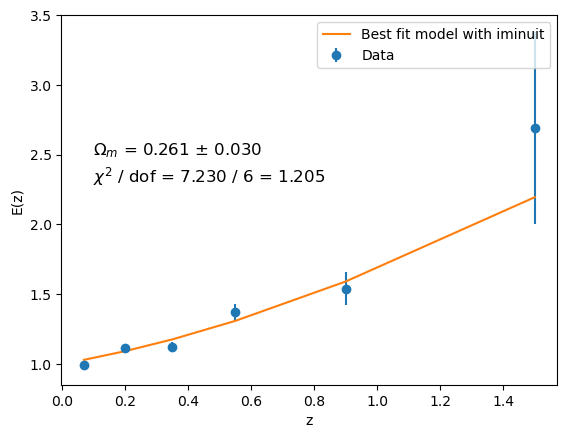

In [63]:
#draw data and fit line
plt.errorbar(z, E, yerr=E_err, fmt='o', label='Data')
plt.plot(z, model(z, m.values['Omega_m']), label='Best fit model with iminuit')
#display the best fit parameters and their errors
fit_info_0 = [f"$\Omega_m$ = {m.values['Omega_m']:.3f} \u00b1 {m.errors['Omega_m']:.3f}"]
fit_info_1 = [f"$\chi^2$ / dof = {m.fval:.3f} / {len(z)} = {m.fval/len(z):.3f}"]
plt.text(0.1, 2.5, '\n'.join(fit_info_0), fontsize=12)
plt.text(0.1, 2.3, '\n'.join(fit_info_1), fontsize=12)
plt.xlabel('z')
plt.ylabel('E(z)')
plt.legend()
plt.show()


In [64]:
#Task2: Fit the model to the data with the covariance matrix using the iminuit package

In [65]:
#the initial covariance matrix
cov_with_sym = np.array([[1.000, 0.000, 0.000, 0.000, 0.000, 0.000],
                        [0.400, 1.000, 0.000, 0.000, 0.000, 0.000],
                        [0.520, -0.130, 1.000, 0.000, 0.000, 0.000],
                        [0.350, 0.350, -0.180, 1.000, 0.000, 0.000],
                        [0.020, -0.080, 0.190, -0.410, 1.000, 0.000],
                        [0.000, -0.060, -0.050, 0.160, -0.210, 1.000]])

#we get correlation matrix without symmetry
def change_sym(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            matrix[i][j] = matrix[j][i]
    return matrix

cov_without_sym = change_sym(cov_with_sym)


#Now, this is the bar cov, which equals to cov divided by uncertainty, we now need to find the cov without bar
def change_bar(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            matrix[i][j] = matrix[i][j] * E_err[i] * E_err[j]
    return matrix

cov = change_bar(cov_without_sym)


#In the end, we need to calculate the inverse matrix of cov
cov_inverse = np.linalg.inv(cov)

In [66]:
#define the newest least square function
row_num = len(cov_inverse)
column_num = len(cov_inverse[0])
def new_LSQ(Omega_m):
    return np.sum((E - model(z , Omega_m)) * cov_inverse * (E - model(z , Omega_m)))

#we set the initial value of Omega_m to be 0.3
n = Minuit(new_LSQ, Omega_m=0.3)
n.migrad()  # finds minimum of least_squares function
n.hesse()   # accurately computes uncertainties
    

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6.931                      │              Nfcn = 21               │
│ EDM = 2.55e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Omega_m │   0.266   │   0.030   │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬──────────┐
│         │  Omega_m │
├─────────┼──────────┤
│ Omega_m │ 0.000931 │
└─────────┴──────────┘

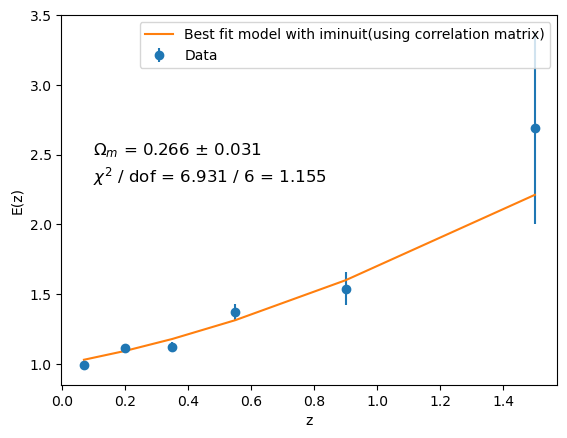

In [67]:
#draw data and fit line
plt.errorbar(z, E, yerr=E_err, fmt='o', label='Data')
plt.plot(z, model(z, n.values['Omega_m']), label='Best fit model with iminuit(using correlation matrix)')
#display the best fit parameters and their errors
fit_info_0 = [f"$\Omega_m$ = {n.values['Omega_m']:.3f} \u00b1 {n.errors['Omega_m']:.3f}"]
fit_info_1 = [f"$\chi^2$ / dof = {n.fval:.3f} / {len(z)} = {n.fval/len(z):.3f}"]
plt.text(0.1, 2.5, '\n'.join(fit_info_0), fontsize=12)
plt.text(0.1, 2.3, '\n'.join(fit_info_1), fontsize=12)
plt.xlabel('z')
plt.ylabel('E(z)')
plt.legend()
plt.show()


In [68]:
#Task 3: Now instead we use the dark energy model, which we expect Omega to be 0.3, and W to be -1

In [69]:
def dark_model(z, Omega_m , w):
    return np.sqrt(Omega_m*(1+z)**3 + (1-Omega_m)*(1+z)**(3*(1+w)))

In [70]:
#Our z and E are the same as before
#Let's first fit the model without the covariance matrix
#we set the initial value of Omega_m to be 0.3, and w to be -1
def LSQ_dark(Omega_m, w):
        return np.sum(((dark_model(z, Omega_m, w) - E)/E_err)**2)
m = Minuit(LSQ_dark, Omega_m=0.3, w=-1)
m.migrad()  # finds minimum of least_squares function
m.hesse()   # accurately computes uncertainties

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.173                      │              Nfcn = 47               │
│ EDM = 2.22e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Omega_m │   0.28    │   0.10    │            │            │         │         │       │
│ 1 │ w       │   -1.06   │   0.25    │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬─────────────────┐
│         │ Omega_m       w │
├─────────┼─────────────────┤
│ Omega_m │ 0.00925  -0.023 │
│       w │  -0.023  0.0631 │
└─────────┴─────────────────┘

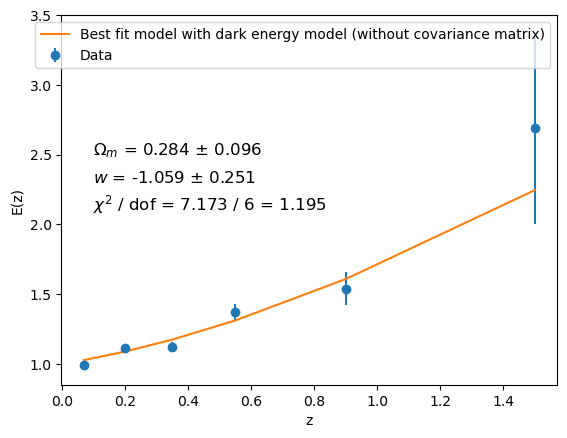

In [71]:
#Plot the data and the best fit model using the dark energy model and without the covariance matrix
plt.errorbar(z, E, yerr=E_err, fmt='o', label='Data')
plt.plot(z, dark_model(z, m.values['Omega_m'], m.values['w']), label='Best fit model with dark energy model (without covariance matrix)')
#display the best fit parameters and their errors
fit_info_0 = [f"$\Omega_m$ = {m.values['Omega_m']:.3f} \u00b1 {m.errors['Omega_m']:.3f}"]
fit_info_1 = [f"$w$ = {m.values['w']:.3f} \u00b1 {m.errors['w']:.3f}"]
fit_info_2 = [f"$\chi^2$ / dof = {m.fval:.3f} / {len(z)} = {m.fval/len(z):.3f}"]
plt.text(0.1, 2.5, '\n'.join(fit_info_0), fontsize=12)
plt.text(0.1, 2.3, '\n'.join(fit_info_1), fontsize=12)
plt.text(0.1, 2.1, '\n'.join(fit_info_2), fontsize=12)
plt.xlabel('z')
plt.ylabel('E(z)')
plt.legend()
plt.show()

In [72]:
#Now, we fit the model with the covariance matrix
#we set the initial value of Omega_m to be 0.3, and w to be -1
def new_LSQ_dark(Omega_m, w):
    return np.sum((E - dark_model(z , Omega_m, w)) * cov_inverse * (E - dark_model(z , Omega_m, w)))
m = Minuit(new_LSQ_dark, Omega_m=0.3, w=-1)
m.migrad()  # finds minimum of least_squares function
m.hesse()   # accurately computes uncertainties

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6.733                      │              Nfcn = 46               │
│ EDM = 3.15e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Omega_m │   0.30    │   0.07    │            │            │         │         │       │
│ 1 │ w       │   -1.09   │   0.21    │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬─────────────────┐
│         │ Omega_m       w │
├─────────┼─────────────────┤
│ Omega_m │ 0.00543 -0.0141 │
│       w │ -0.0141  0.0437 │
└─────────┴─────────────────┘

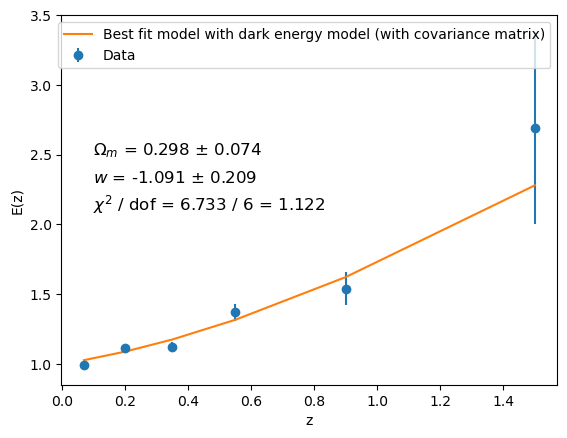

In [73]:
#Plot the data and the best fit model using the dark energy model and with the covariance matrix
plt.errorbar(z, E, yerr=E_err, fmt='o', label='Data')
plt.plot(z, dark_model(z, m.values['Omega_m'], m.values['w']), label='Best fit model with dark energy model (with covariance matrix)')
#display the best fit parameters and their errors
fit_info_0 = [f"$\Omega_m$ = {m.values['Omega_m']:.3f} \u00b1 {m.errors['Omega_m']:.3f}"]
fit_info_1 = [f"$w$ = {m.values['w']:.3f} \u00b1 {m.errors['w']:.3f}"]
fit_info_2 = [f"$\chi^2$ / dof = {m.fval:.3f} / {len(z)} = {m.fval/len(z):.3f}"]
plt.text(0.1, 2.5, '\n'.join(fit_info_0), fontsize=12)
plt.text(0.1, 2.3, '\n'.join(fit_info_1), fontsize=12)
plt.text(0.1, 2.1, '\n'.join(fit_info_2), fontsize=12)
plt.xlabel('z')
plt.ylabel('E(z)')
plt.legend()
plt.show()


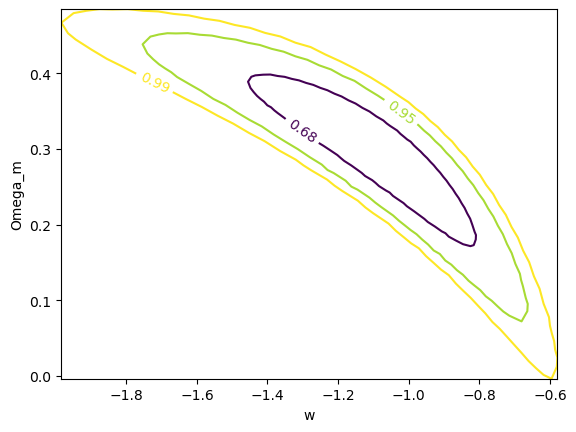

In [74]:
#Now I want to draw the contour plot of Omega_m and w
m.draw_mncontour('w', 'Omega_m', cl=(0.68, 0.95, 0.99))

In [75]:
#Task 4: Fit the model to the data with the covariance matrix using the iminuit package, but now we use the H(z)
#We expect Omega to be 0.3, and W to be -1, and H0 to be 70

In [76]:
def h_model(z, H_0, Omega_m , w):
    return H_0 * np.sqrt(Omega_m*(1+z)**3 + (1-Omega_m)*(1+z)**(3*(1+w)))

In [77]:
f = r"C:\Users\hao14\Documents\WeChat Files\wxid_nlkrngxwwaz012\FileStorage\File\2023-06\Hzdata.txt"
z = np.loadtxt(f, usecols=(0))
H = np.loadtxt(f, usecols=(1))
H_err = np.loadtxt(f, usecols=(2))

#let's write it out so that z, H, H_err are all arrays
z = np.array(z)
H = np.array(H)
H_err = np.array(H_err)

#Let's write z, H, H_err out so that they can be used in another computer
z = np.array([0.07  , 0.09  , 0.12  , 0.17  , 0.179 , 0.199 , 0.2   , 0.27  ,
            0.28  , 0.352 , 0.3802, 0.4   , 0.4004, 0.4247, 0.4497, 0.47  ,
            0.4783, 0.48  , 0.593 , 0.68  , 0.781 , 0.875 , 0.88  , 0.9   ,
            1.037 , 1.3   , 1.363 , 1.43  , 1.53  , 1.75  , 1.965])
H = np.array([69. ,  69. ,  68.6,  83. ,  75. ,  75. ,  72.9,  77. ,  88.8,
            83. ,  83. ,  95. ,  77. ,  87.1,  92.8,  89. ,  80.9,  97. ,
            104. ,  92. , 105. , 125. ,  90. , 117. , 154. , 168. , 160. ,
            177. , 140. , 202. , 186.5])
H_err = np.array([19.6, 12. , 26.2,  8. ,  4. ,  5. , 29.6, 14. , 36.6, 14. , 13.5,
                17. , 10.2, 11.2, 12.9, 49.6,  9. , 62. , 13. ,  8. , 12. , 17. ,
                40. , 23. , 20. , 17. , 33.6, 18. , 14. , 40. , 50.4])

In [78]:
#Since we don't have correlation matrix, we can fit the model without the covariance matrix
def LSQ_h(H_0, Omega_m, w):
        return np.sum(((h_model(z, H_0, Omega_m, w) - H)/H_err)**2)
m = Minuit(LSQ_h, H_0=70, Omega_m=0.3, w=-1)
m.migrad()  # finds minimum of least_squares function
m.hesse()   # accurately computes uncertainties

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.36                      │              Nfcn = 97               │
│ EDM = 2.12e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ H_0     │    71     │     8     │            │            │         │         │       │
│ 1 │ Omega_m │   0.32    │   0.06    │            │            │         │         │       │
│ 2 │ w       │   -1.2    │    0.7    │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬─────────────────────────┐
│         │     H_0 Omega_m       w │
├─────────┼─────────────────────────┤
│     H_0 │    69.1  -0.243   -5.25 │
│ Omega_m │  -0.243 0.00314 0.00713 │
│       w │   -5.25 0.00713    0.48 │
└─────────┴─────────────────────────┘

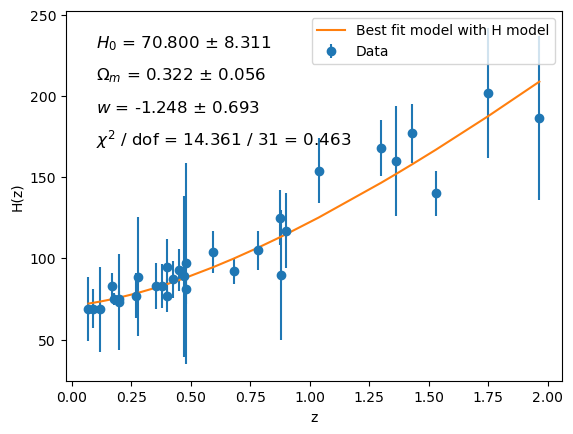

In [79]:
#Plot the data and the best fit model using the H model
plt.errorbar(z, H, yerr=H_err, fmt='o', label='Data')
plt.plot(z, h_model(z, m.values['H_0'], m.values['Omega_m'], m.values['w']), label='Best fit model with H model')
#display the best fit parameters and their errors
fit_info_0 = [f"$H_0$ = {m.values['H_0']:.3f} \u00b1 {m.errors['H_0']:.3f}"]
fit_info_1 = [f"$\Omega_m$ = {m.values['Omega_m']:.3f} \u00b1 {m.errors['Omega_m']:.3f}"]
fit_info_2 = [f"$w$ = {m.values['w']:.3f} \u00b1 {m.errors['w']:.3f}"]
fit_info_3 = [f"$\chi^2$ / dof = {m.fval:.3f} / {len(z)} = {m.fval/len(z):.3f}"]
plt.text(0.1, 230, '\n'.join(fit_info_0), fontsize=12)
plt.text(0.1, 210, '\n'.join(fit_info_1), fontsize=12)
plt.text(0.1, 190, '\n'.join(fit_info_2), fontsize=12)
plt.text(0.1, 170, '\n'.join(fit_info_3), fontsize=12)
plt.xlabel('z')
plt.ylabel('H(z)')
plt.legend()
plt.show()
